______________
Importing necessary libraries and setting global variables

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from scipy.stats import mode
from sklearn.metrics import average_precision_score
import random
from sklearn.metrics import plot_precision_recall_curve
from sklearn.preprocessing import StandardScaler
from models import UnbalancedBagger, UnbalancedBaggerNoSampling
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

RANDOM_SEED = 12345

In [2]:
original_df = pd.read_csv("datasets/diabetes.csv")


In [3]:
original_df.describe()
#weird that "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI" have zero values, imputate mean values

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
def imputation(data, columns):
    for c in columns:
         if c in data.columns:
             data[c].replace(0, np.nan,inplace=True)
             data[c].fillna(data[c].mean(), inplace=True)
    return data


In [5]:
original_df = imputation(original_df, ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"])

original_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.790942,85.021108,6.875151,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.153420,155.548223,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.548223,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


<AxesSubplot:title={'center':'Plot over class imbalance'}>

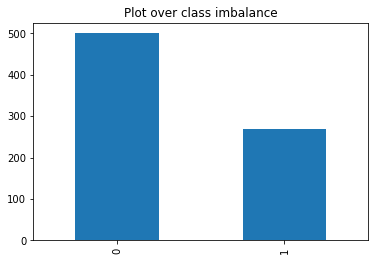

In [6]:
total_labels = original_df.Outcome.value_counts()
total_labels.plot(kind='bar', title='Plot over class imbalance')

In [7]:
#we can now split attributes and class label
X = original_df.drop('Outcome', axis=1)
y = original_df.Outcome

X.describe()

#data_standardized used for SVC
scaler = StandardScaler()
data_standardized = scaler.fit_transform(X)

In [8]:
X_training,X_testing,y_training,y_testing, = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)
x_train, x_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.3, random_state=RANDOM_SEED)

#standardized split for SVC
X_training_svc,X_testing_svc,y_training_svc,y_testing_svc, = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)
x_train_svc, x_val_svc, y_train_svc, y_val_svc = train_test_split(X_training, y_training, test_size=0.3, random_state=RANDOM_SEED)

In [9]:
#Methods for sampling
ros = RandomOverSampler(random_state=RANDOM_SEED)
rus = RandomUnderSampler(random_state=RANDOM_SEED)
smote = SMOTE(random_state=RANDOM_SEED, sampling_strategy='minority')

#Classifiers
dtc = DecisionTreeClassifier(random_state=RANDOM_SEED)
svc = SVC(random_state=RANDOM_SEED)


In [10]:
def smote_technique(X,y):
    x_sample, y_sample = smote.fit_sample(X, y)
    return x_sample,y_sample

def random_oversampling_technique(X,y):
    x_sample, y_sample = ros.fit_sample(x_train, y_train)
    return x_sample,y_sample

def random_undersampling_technique(X,y):
    x_sample, y_sample = rus.fit_sample(x_train, y_train)
    return x_sample,y_sample

In [18]:
#new method, using ros, rus and smote
sampling_techniques = [ros, rus, smote]

classifier_dtc = UnbalancedBagger.unbalanced_bagger(x_train, y_train, 10, sampling_techniques,base_estimator=dtc,random_seed=RANDOM_SEED)
classifier_svc = UnbalancedBagger.unbalanced_bagger(x_train_svc, y_train_svc, 10, sampling_techniques,base_estimator=svc,random_seed=RANDOM_SEED)

y_score_dtc = classifier_dtc(X_testing)
y_score_svc = classifier_svc(X_testing_svc)

print("Data balanced by Unbalanced Bagger")
print("\nValidation Results (Decision Tree):")
print(classification_report(y_val, classifier_dtc(x_val)))
print("\nValidation Results (SVC):")
print(classification_report(y_val_svc, classifier_svc(x_val_svc)))

print("\nTest Results (Decision Tree):")
print(classification_report(y_testing, y_score_dtc))
auprc_dtc = average_precision_score(y_testing,y_score_dtc)
auc_dtc = roc_auc_score(y_testing,y_score_dtc)
print("AUPRC: ", auprc_dtc)
print("AUC: ", auc_dtc)
print("\nTest Results (SVC):")
print(classification_report(y_testing_svc, y_score_svc))
auprc_svc = average_precision_score(y_testing,y_score_svc)
auc_svc = roc_auc_score(y_testing,y_score_svc)
print("AUPRC: ", auprc_svc)
print("AUC: ", auc_svc)

Data balanced by Unbalanced Bagger

Validation Results (Decision Tree):
              precision    recall  f1-score   support

           0       0.67      0.80      0.73       102
           1       0.50      0.33      0.40        60

    accuracy                           0.63       162
   macro avg       0.59      0.57      0.57       162
weighted avg       0.61      0.63      0.61       162


Validation Results (SVC):
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       102
           1       0.63      0.68      0.66        60

    accuracy                           0.73       162
   macro avg       0.72      0.72      0.72       162
weighted avg       0.74      0.73      0.74       162


Test Results (Decision Tree):
              precision    recall  f1-score   support

           0       0.78      0.77      0.78       158
           1       0.52      0.53      0.53        73

    accuracy                           0.70       23

In [24]:
#new method, using ros
sampling_techniques = [ros]

classifier_dtc = UnbalancedBagger.unbalanced_bagger(x_train, y_train, 10, sampling_techniques,base_estimator=dtc,random_seed=RANDOM_SEED)
classifier_svc = UnbalancedBagger.unbalanced_bagger(x_train_svc, y_train_svc, 10, sampling_techniques,base_estimator=svc,random_seed=RANDOM_SEED)

y_score_dtc = classifier_dtc(X_testing)
y_score_svc = classifier_svc(X_testing_svc)

print("Data balanced by Unbalanced Bagger (Only Oversampling)")
print("\nValidation Results (Decision Tree):")
print(classification_report(y_val, classifier_dtc(x_val)))
print("\nValidation Results (SVC):")
print(classification_report(y_val_svc, classifier_svc(x_val_svc)))

print("\nTest Results (Decision Tree):")
print(classification_report(y_testing, y_score_dtc))
auprc_dtc = average_precision_score(y_testing,y_score_dtc)
auc_dtc = roc_auc_score(y_testing,y_score_dtc)
print("AUPRC: ", auprc_dtc)
print("AUC: ", auc_dtc)
print("\nTest Results (SVC):")
print(classification_report(y_testing_svc, y_score_svc))
auprc_svc = average_precision_score(y_testing,y_score_svc)
auc_svc = roc_auc_score(y_testing,y_score_svc)
print("AUPRC: ", auprc_svc)
print("AUC: ", auc_svc)

Data balanced by Unbalanced Bagger (Only Oversampling)

Validation Results (Decision Tree):
              precision    recall  f1-score   support

           0       0.73      0.80      0.76       102
           1       0.59      0.48      0.53        60

    accuracy                           0.69       162
   macro avg       0.66      0.64      0.65       162
weighted avg       0.68      0.69      0.68       162


Validation Results (SVC):
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       102
           1       0.62      0.67      0.65        60

    accuracy                           0.73       162
   macro avg       0.71      0.72      0.71       162
weighted avg       0.73      0.73      0.73       162


Test Results (Decision Tree):
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       158
           1       0.65      0.51      0.57        73

    accuracy                    

In [25]:
#new method, using rus
sampling_techniques = [rus]

classifier_dtc = UnbalancedBagger.unbalanced_bagger(x_train, y_train, 10, sampling_techniques,base_estimator=dtc,random_seed=RANDOM_SEED)
classifier_svc = UnbalancedBagger.unbalanced_bagger(x_train_svc, y_train_svc, 10, sampling_techniques,base_estimator=svc,random_seed=RANDOM_SEED)

y_score_dtc = classifier_dtc(X_testing)
y_score_svc = classifier_svc(X_testing_svc)

print("Data balanced by Unbalanced Bagger (Only Undersampling)")
print("\nValidation Results (Decision Tree):")
print(classification_report(y_val, classifier_dtc(x_val)))
print("\nValidation Results (SVC):")
print(classification_report(y_val_svc, classifier_svc(x_val_svc)))

print("\nTest Results (Decision Tree):")
print(classification_report(y_testing, y_score_dtc))
auprc_dtc = average_precision_score(y_testing,y_score_dtc)
auc_dtc = roc_auc_score(y_testing,y_score_dtc)
print("AUPRC: ", auprc_dtc)
print("AUC: ", auc_dtc)
print("\nTest Results (SVC):")
print(classification_report(y_testing_svc, y_score_svc))
auprc_svc = average_precision_score(y_testing,y_score_svc)
auc_svc = roc_auc_score(y_testing,y_score_svc)
print("AUPRC: ", auprc_svc)
print("AUC: ", auc_svc)

Data balanced by Unbalanced Bagger (Only Undersampling)

Validation Results (Decision Tree):
              precision    recall  f1-score   support

           0       0.74      0.73      0.73       102
           1       0.55      0.57      0.56        60

    accuracy                           0.67       162
   macro avg       0.64      0.65      0.65       162
weighted avg       0.67      0.67      0.67       162


Validation Results (SVC):
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       102
           1       0.69      0.62      0.65        60

    accuracy                           0.75       162
   macro avg       0.74      0.73      0.73       162
weighted avg       0.75      0.75      0.75       162


Test Results (Decision Tree):
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       158
           1       0.48      0.56      0.52        73

    accuracy                   

In [26]:
#new method, using smote
sampling_techniques = [smote]

classifier_dtc = UnbalancedBagger.unbalanced_bagger(x_train, y_train, 10, sampling_techniques,base_estimator=dtc,random_seed=RANDOM_SEED)
classifier_svc = UnbalancedBagger.unbalanced_bagger(x_train_svc, y_train_svc, 10, sampling_techniques,base_estimator=svc,random_seed=RANDOM_SEED)

y_score_dtc = classifier_dtc(X_testing)
y_score_svc = classifier_svc(X_testing_svc)

print("Data balanced by Unbalanced Bagger (Only SMOTE)")
print("\nValidation Results (Decision Tree):")
print(classification_report(y_val, classifier_dtc(x_val)))
print("\nValidation Results (SVC):")
print(classification_report(y_val_svc, classifier_svc(x_val_svc)))

print("\nTest Results (Decision Tree):")
print(classification_report(y_testing, y_score_dtc))
auprc_dtc = average_precision_score(y_testing,y_score_dtc)
auc_dtc = roc_auc_score(y_testing,y_score_dtc)
print("AUPRC: ", auprc_dtc)
print("AUC: ", auc_dtc)
print("\nTest Results (SVC):")
print(classification_report(y_testing_svc, y_score_svc))
auprc_svc = average_precision_score(y_testing,y_score_svc)
auc_svc = roc_auc_score(y_testing,y_score_svc)
print("AUPRC: ", auprc_svc)
print("AUC: ", auc_svc)

Data balanced by Unbalanced Bagger (Only SMOTE)

Validation Results (Decision Tree):
              precision    recall  f1-score   support

           0       0.68      0.75      0.72       102
           1       0.49      0.40      0.44        60

    accuracy                           0.62       162
   macro avg       0.59      0.58      0.58       162
weighted avg       0.61      0.62      0.61       162


Validation Results (SVC):
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       102
           1       0.63      0.55      0.59        60

    accuracy                           0.72       162
   macro avg       0.69      0.68      0.69       162
weighted avg       0.71      0.72      0.71       162


Test Results (Decision Tree):
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       158
           1       0.60      0.67      0.64        73

    accuracy                           

In [27]:
#new method, using smote and ros
sampling_techniques = [smote, ros]

classifier_dtc = UnbalancedBagger.unbalanced_bagger(x_train, y_train, 10, sampling_techniques,base_estimator=dtc,random_seed=RANDOM_SEED)
classifier_svc = UnbalancedBagger.unbalanced_bagger(x_train_svc, y_train_svc, 10, sampling_techniques,base_estimator=svc,random_seed=RANDOM_SEED)

y_score_dtc = classifier_dtc(X_testing)
y_score_svc = classifier_svc(X_testing_svc)

print("Data balanced by Unbalanced Bagger (Only SMOTE and Random Oversampling)")
print("\nValidation Results (Decision Tree):")
print(classification_report(y_val, classifier_dtc(x_val)))
print("\nValidation Results (SVC):")
print(classification_report(y_val_svc, classifier_svc(x_val_svc)))

print("\nTest Results (Decision Tree):")
print(classification_report(y_testing, y_score_dtc))
auprc_dtc = average_precision_score(y_testing,y_score_dtc)
auc_dtc = roc_auc_score(y_testing,y_score_dtc)
print("AUPRC: ", auprc_dtc)
print("AUC: ", auc_dtc)
print("\nTest Results (SVC):")
print(classification_report(y_testing_svc, y_score_svc))
auprc_svc = average_precision_score(y_testing,y_score_svc)
auc_svc = roc_auc_score(y_testing,y_score_svc)
print("AUPRC: ", auprc_svc)
print("AUC: ", auc_svc)

Data balanced by Unbalanced Bagger (Only SMOTE and Random Oversampling)

Validation Results (Decision Tree):
              precision    recall  f1-score   support

           0       0.68      0.84      0.75       102
           1       0.56      0.33      0.42        60

    accuracy                           0.65       162
   macro avg       0.62      0.59      0.59       162
weighted avg       0.64      0.65      0.63       162


Validation Results (SVC):
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       102
           1       0.65      0.58      0.61        60

    accuracy                           0.73       162
   macro avg       0.71      0.70      0.70       162
weighted avg       0.72      0.73      0.73       162


Test Results (Decision Tree):
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       158
           1       0.64      0.59      0.61        73

    accuracy   

In [19]:
classifier_dtc = UnbalancedBaggerNoSampling.unbalanced_bagger_no_sampling(x_train, y_train, 10,base_estimator=dtc,random_seed=RANDOM_SEED)
classifier_svc = UnbalancedBaggerNoSampling.unbalanced_bagger_no_sampling(x_train_svc, y_train_svc, 10,base_estimator=svc,random_seed=RANDOM_SEED)
y_score_dtc = classifier_dtc(X_testing)
y_score_svc = classifier_svc(X_testing_svc)

print("unbalanced_bagger_no_sampling")
print("\nValidation Results (Decision Tree):")
print(classification_report(y_val, classifier_dtc(x_val)))
print("\nValidation Results (SVC):")
print(classification_report(y_val_svc, classifier_svc(x_val_svc)))

print("\nTest Results (Decision Tree):")
print(classification_report(y_testing, y_score_dtc))
auprc_dtc = average_precision_score(y_testing,y_score_dtc)
auc_dtc = roc_auc_score(y_testing,y_score_dtc)
print("AUPRC: ", auprc_dtc)
print("AUC: ", auc_dtc)
print("\nTest Results (SVC):")
print(classification_report(y_testing_svc, y_score_svc))
auprc_svc = average_precision_score(y_testing,y_score_svc)
auc_svc = roc_auc_score(y_testing,y_score_svc)
print("AUPRC: ", auprc_svc)
print("AUC: ", auc_svc)

unbalanced_bagger_no_sampling

Validation Results (Decision Tree):
              precision    recall  f1-score   support

           0       0.69      0.78      0.73       102
           1       0.52      0.40      0.45        60

    accuracy                           0.64       162
   macro avg       0.61      0.59      0.59       162
weighted avg       0.63      0.64      0.63       162


Validation Results (SVC):
              precision    recall  f1-score   support

           0       0.72      0.91      0.81       102
           1       0.73      0.40      0.52        60

    accuracy                           0.72       162
   macro avg       0.72      0.66      0.66       162
weighted avg       0.72      0.72      0.70       162


Test Results (Decision Tree):
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       158
           1       0.57      0.59      0.58        73

    accuracy                           0.73       231
   

In [20]:
#Train on original data
print("Original data")
dtc.fit(x_train, y_train)
svc.fit(x_train_svc,y_train_svc)

print("\nValidation Results (Decision Tree):")
print(classification_report(y_val, dtc.predict(x_val)))
print("\nValidation Results (SVC):")
print(classification_report(y_val_svc, svc.predict(x_val_svc)))

print("\nTest Results (Decision Tree):")
print(classification_report(y_testing, dtc.predict(X_testing)))
auprc_dtc = average_precision_score(y_testing,dtc.predict(X_testing))
auc_dtc = roc_auc_score(y_testing,dtc.predict(X_testing))
print("AUPRC: ", auprc_dtc)
print("AUC: ", auc_dtc)
print("\nTest Results (SVC):")
print(classification_report(y_testing_svc, svc.predict(X_testing_svc)))
auprc_svc = average_precision_score(y_testing,svc.predict(X_testing))
auc_svc = roc_auc_score(y_testing,svc.predict(X_testing))
print("AUPRC: ", auprc_svc)
print("AUC: ", auc_svc)

Original data

Validation Results (Decision Tree):
              precision    recall  f1-score   support

           0       0.72      0.75      0.73       102
           1       0.54      0.50      0.52        60

    accuracy                           0.65       162
   macro avg       0.63      0.62      0.62       162
weighted avg       0.65      0.65      0.65       162


Validation Results (SVC):
              precision    recall  f1-score   support

           0       0.73      0.91      0.81       102
           1       0.74      0.43      0.55        60

    accuracy                           0.73       162
   macro avg       0.74      0.67      0.68       162
weighted avg       0.74      0.73      0.71       162


Test Results (Decision Tree):
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       158
           1       0.58      0.62      0.60        73

    accuracy                           0.74       231
   macro avg       

In [21]:
#Train on SMOTE
sampled_dtc_x, sampled_dtc_y = smote_technique(x_train,y_train)
sampled_svc_x, sampled_svc_y = smote_technique(x_train_svc,y_train_svc)

dtc.fit(sampled_dtc_x,sampled_dtc_y)
svc.fit(sampled_svc_x,sampled_svc_y)

print("Data balanced by SMOTE")
print("\nValidation Results (Decision Tree):")
print(classification_report(y_val, dtc.predict(x_val)))
print("\nValidation Results (SVC):")
print(classification_report(y_val, svc.predict(x_val_svc)))

print("\nTest Results (Decision Tree):")
print(classification_report(y_testing, dtc.predict(X_testing)))
auprc_dtc = average_precision_score(y_testing,dtc.predict(X_testing))
auc_dtc = roc_auc_score(y_testing,dtc.predict(X_testing))
print("AUPRC: ", auprc_dtc)
print("AUC: ", auc_dtc)
print("\nTest Results (SVC):")
print(classification_report(y_testing, svc.predict(X_testing_svc)))
auprc_svc = average_precision_score(y_testing,svc.predict(X_testing))
auc_svc = roc_auc_score(y_testing,svc.predict(X_testing))
print("AUPRC: ", auprc_svc)
print("AUC: ", auc_svc)

Data balanced by SMOTE

Validation Results (Decision Tree):
              precision    recall  f1-score   support

           0       0.72      0.77      0.75       102
           1       0.57      0.50      0.53        60

    accuracy                           0.67       162
   macro avg       0.65      0.64      0.64       162
weighted avg       0.67      0.67      0.67       162


Validation Results (SVC):
              precision    recall  f1-score   support

           0       0.76      0.79      0.78       102
           1       0.62      0.58      0.60        60

    accuracy                           0.72       162
   macro avg       0.69      0.69      0.69       162
weighted avg       0.71      0.72      0.71       162


Test Results (Decision Tree):
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       158
           1       0.59      0.60      0.60        73

    accuracy                           0.74       231
   macro a

In [22]:
#Train on Random Oversampling
sampled_dtc_x, sampled_dtc_y = random_oversampling_technique(x_train,y_train)
sampled_svc_x, sampled_svc_y = random_oversampling_technique(x_train_svc,y_train_svc)

dtc.fit(sampled_dtc_x,sampled_dtc_y)
svc.fit(sampled_svc_x,sampled_svc_y)

print("Data balanced by Random Oversampling")
print("\nValidation Results (Decision tree):")
print(classification_report(y_val, dtc.predict(x_val)))
print("\nValidation Results (SVC):")
print(classification_report(y_val, svc.predict(x_val_svc)))

print("\nTest Results (Decision tree):")
print(classification_report(y_testing, dtc.predict(X_testing)))
auprc_dtc = average_precision_score(y_testing,dtc.predict(X_testing))
auc_dtc = roc_auc_score(y_testing,dtc.predict(X_testing))
print("AUPRC: ", auprc_dtc)
print("AUC: ", auc_dtc)
print("\nTest Results (SVC):")
print(classification_report(y_testing, svc.predict(X_testing_svc)))
auprc_svc = average_precision_score(y_testing,svc.predict(X_testing))
auc_svc = roc_auc_score(y_testing,svc.predict(X_testing))
print("AUPRC: ", auprc_svc)
print("AUC: ", auc_svc)

Data balanced by Random Oversampling

Validation Results (Decision tree):
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       102
           1       0.65      0.52      0.57        60

    accuracy                           0.72       162
   macro avg       0.70      0.68      0.68       162
weighted avg       0.71      0.72      0.71       162


Validation Results (SVC):
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       102
           1       0.64      0.58      0.61        60

    accuracy                           0.72       162
   macro avg       0.70      0.69      0.70       162
weighted avg       0.72      0.72      0.72       162


Test Results (Decision tree):
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       158
           1       0.58      0.60      0.59        73

    accuracy                           0.74       

In [23]:
#Train on Random Undersampling
sampled_dtc_x, sampled_dtc_y = random_undersampling_technique(x_train,y_train)
sampled_svc_x, sampled_svc_y = random_undersampling_technique(x_train_svc,y_train_svc)

dtc.fit(sampled_dtc_x,sampled_dtc_y)
svc.fit(sampled_svc_x,sampled_svc_y)

print("Data balanced by Random Undersampling")
print("\nValidation Results (Decision tree):")
print(classification_report(y_val, dtc.predict(x_val)))
print("\nValidation Results (SVC):")
print(classification_report(y_val, svc.predict(x_val_svc)))

print("\nTest Results (Decision tree):")
print(classification_report(y_testing, dtc.predict(X_testing)))
auc_dtc = roc_auc_score(y_testing,dtc.predict(X_testing))
print("AUPRC: ", auprc_dtc)
print("AUC: ", auc_dtc)
print("\nTest Results (SVC):")
print(classification_report(y_testing, svc.predict(X_testing_svc)))
auprc_svc = average_precision_score(y_testing,svc.predict(X_testing))
auc_svc = roc_auc_score(y_testing,svc.predict(X_testing))
print("AUPRC: ", auprc_svc)
print("AUC: ", auc_svc)

Data balanced by Random Undersampling

Validation Results (Decision tree):
              precision    recall  f1-score   support

           0       0.71      0.70      0.70       102
           1       0.50      0.52      0.51        60

    accuracy                           0.63       162
   macro avg       0.60      0.61      0.61       162
weighted avg       0.63      0.63      0.63       162


Validation Results (SVC):
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       102
           1       0.57      0.58      0.58        60

    accuracy                           0.69       162
   macro avg       0.66      0.66      0.66       162
weighted avg       0.69      0.69      0.69       162


Test Results (Decision tree):
              precision    recall  f1-score   support

           0       0.83      0.70      0.76       158
           1       0.52      0.68      0.59        73

    accuracy                           0.70      